In [1]:
%cd -q ../..

In [ ]:
import json
from collections import Counter, defaultdict
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt

from scotus_metalang.diachronic_analysis.authors import ORDERED_JUSTICES, SCDB_NAME_TO_JUSTICE

pd.set_option("display.max_columns", None)

In [2]:
scdb = pd.read_csv("data/scdb/SCDB_2023_01_justiceCentered_Docket.csv", encoding="cp1252")
scdb_86_onward = scdb[(scdb.term >= 1986) & (scdb.term <= 2019)]

def get_scdb_docket_numbers(docket_number):
    """Formats single CAP docket num into list of possible SCDB docket nums."""
    if docket_number == "141-orig":
        return ["22O141"]  # Special case that doesn't seem to follow any of the rules
    if "orig" in docket_number.lower():
        num = docket_number.split("-")[0]
        return [f"{num}, Orig.", f"No. {num}, Orig.", f"{num} ORIG"]
    else:
        return [docket_number]

def get_term(df, docket_numbers):
    return df[df["docket"].isin(docket_numbers)]["term"].iloc[0]

def get_expected_opinions(df, docket_numbers):
    return len(df[(df["docket"].isin(docket_numbers)) & (df["opinion"] == 2.0)])

def get_expected_opinion_authors(df, docket_numbers):
    result = []
    for scdb_author in df[(df["docket"].isin(docket_numbers)) &
                          (scdb_86_onward["opinion"] == 2.0)]["justiceName"].values:
        result.append(SCDB_NAME_TO_JUSTICE[scdb_author])
    return result

In [3]:
get_expected_opinion_authors(scdb_86_onward, ["13-1433"])

['thomas', 'alito', 'sotomayor']

### Calculate opinion hit rate by author

In [4]:
# Gather opinions from both sources by docket number
cap_opinions_by_docket_num = defaultdict(list)
scdb_opinions_by_docket_num = {}
for opinion_filepath in Path("data/cap/known_authors").glob("*/*.json"):
    docket_number = opinion_filepath.stem
    author = opinion_filepath.parent.name
    cap_opinions_by_docket_num[docket_number].append(author)
    scdb_docket_numbers = get_scdb_docket_numbers(docket_number)
    expected_opinions = get_expected_opinions(scdb_86_onward, scdb_docket_numbers)
    scdb_opinions_by_docket_num[docket_number] = expected_opinions

# Gather opinions by author
actual_opinions_by_author = Counter()
expected_opinions_by_author = Counter()
for docket_number, actual_authors in cap_opinions_by_docket_num.items():
    scdb_docket_numbers = get_scdb_docket_numbers(docket_number)
    expected_authors = get_expected_opinion_authors(scdb_86_onward, scdb_docket_numbers)
    for author in actual_authors:
        actual_opinions_by_author[author] += 1
    # Union because there's at least one case where SCDB is missing an author
    expected_authors = set(expected_authors).union(set(actual_authors))
    for author in expected_authors:
        expected_opinions_by_author[author] += 1

# Compare CAP opinions to SCDB Expectations
print("Percentage of expected opinions retrieved from CAP:")
for author in ORDERED_JUSTICES:
    actual_count = actual_opinions_by_author[author]
    hit_rate = actual_count / expected_opinions_by_author[author]
    print(author, f"{hit_rate:.03f}")

Percentage of expected opinions retrieved from CAP:
brennan 0.976
white 0.986
marshall 0.993
blackmun 0.963
powell 1.000
rehnquist 0.975
stevens 0.966
oconnor 0.971
scalia 0.929
kennedy 0.956
souter 0.932
thomas 0.829
ginsburg 0.881
breyer 0.883
roberts 0.792
alito 0.715
sotomayor 0.737
kagan 0.755
gorsuch 0.612
kavanaugh 0.808


### Plot missing opinions by year

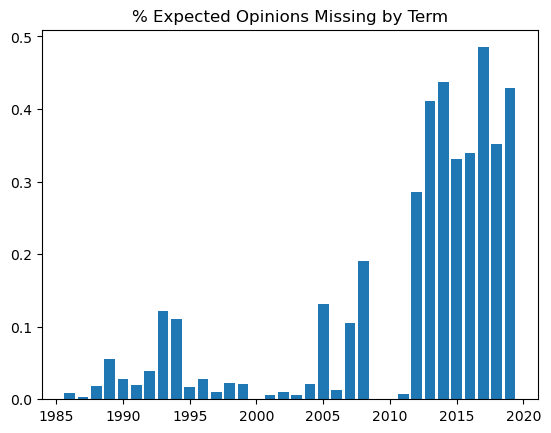

In [5]:
missing_count_by_year = defaultdict(Counter)
expected_count_by_year = defaultdict(Counter)
for docket_number, actual_authors in cap_opinions_by_docket_num.items():
    scdb_docket_numbers = get_scdb_docket_numbers(docket_number)
    expected_authors = get_expected_opinion_authors(scdb_86_onward, scdb_docket_numbers)
    term = get_term(scdb_86_onward, scdb_docket_numbers)
    expected_authors = set(expected_authors).union(set(actual_authors))
    missing_authors = set(expected_authors) - set(actual_authors)
    for author in missing_authors:
        missing_count_by_year[term][author] += 1
    for author in expected_authors:
        expected_count_by_year[term][author] += 1
missing_ratio_by_year = [sum(missing_count_by_year[y].values()) / sum(expected_count_by_year[y].values())
                         for y in sorted(missing_count_by_year)]

plt.bar(sorted(missing_count_by_year.keys()), missing_ratio_by_year)
plt.title("% Expected Opinions Missing by Term")
plt.show()

In [6]:
total_missing = 0
total = 0
for docket_number, expectation in scdb_opinions_by_docket_num.items(
):
    num_missing = expectation - len(cap_opinions_by_docket_num[docket_number])
    if num_missing >= 0:
        total_missing += num_missing
    total += expectation

In [7]:
print(f"{total_missing / (total_missing + total):.03f}")

0.086


In [38]:
missing_by_docket = defaultdict(dict)
for docket_number, actual_authors in cap_opinions_by_docket_num.items():
    scdb_docket_numbers = get_scdb_docket_numbers(docket_number)
    expected_authors = set(get_expected_opinion_authors(scdb_86_onward, scdb_docket_numbers))
    actual_authors = set(actual_authors)
    if len(not_in_scdb := list(actual_authors - expected_authors)) > 0:
        missing_by_docket[docket_number]["not_in_scdb"] = not_in_scdb
    if len(not_in_cap := list(expected_authors- actual_authors)) > 0:
        missing_by_docket[docket_number]["not_in_cap"] = not_in_cap

In [42]:
with open("data/scdb/missing_by_docket_number.json", "w") as f:
    json.dump(missing_by_docket, f)

In [47]:
scdb = pd.read_csv("data/scdb/SCDB_2023_01_justiceCentered_Docket.csv", encoding="cp1252")
scdb_86_onward = scdb[(scdb.term >= 1986) & (scdb.term <= 2019)]